# Cross Validation Classifier with Constructive PCD

## Cross Validation

The cross validation is done by randomly dividing the data into a number of boxes and selecting random boxes as train, test and validation sets. The data is considered for each acquisition run, of every ship. That is, the boxes and selections are done for each acquisition run. Later, they are appended in order to train the classifier with data from every acquisition. This guarantees that most of the signal stochasticity is seen by the classifier.

## Classifier

Classifier trained conidering the data projection onto the PCD's extracted by the constructive model. The neural classifier was trained considering different number of hidden neurons. 

# Results

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas
from sklearn.externals import joblib
# Network import: should be in the path if framework configured correctly
import neuralnet as nn
import PyNN.NeuralNet as PyNNet
import PyNN.TrnInfo as PyTrnInfo
import copy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
import scipy as sc

# Standard styles for each class
dashes = [[],[10,10],[10,4,2,4],[10,5,100,5]] 
colors = ['b','r','g','y']

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.handlelength'] = 3
mpl.rcParams['legend.borderpad'] = 0.3
mpl.rcParams['legend.numpoints'] = 1


classes = np.array(['ClasseA','ClasseB','ClasseC','ClasseD'])
noveltyclasses = np.array(['ClasseA','ClasseB','ClasseC','ClasseD'])
#noveltyclasses = np.array(['ClasseA'])
sonarhome = os.getenv('SONARHOME')
fname = sonarhome + '/data/lofar_data_1024fft_3dec_fromMat.jbl'
pcddir = sonarhome + '/results/classification/novelty/PCD_Constructive/'
clfdir = sonarhome + '/results/classification/novelty/PCD_Classifier/'
nPts = 400

In [12]:
# Load and divide data
globaldata = joblib.load(fname)
cls_data = {}
for cls in classes:
    cls_data[cls] = np.concatenate([y['Signal'][:nPts,] for y in globaldata[cls].values()], axis=1).transpose()
def novelty_data(clsnov, data):
    use_classes = np.sort(np.setdiff1d(data.keys(), clsnov))
    Xnov = np.concatenate([data[cls] for cls in clsnov], axis=0)
    X = np.concatenate([data[cls] for cls in use_classes], axis=0)
    nClass = len(use_classes)
    T = None
    for icls, cls in enumerate(use_classes):
        tot = data[cls].shape[0]
        if nClass == 2:
            aux = -np.ones(1)
            aux[0] = 1 if icls > 0 else -1
        else:
            aux = -np.ones(nClass)
            aux[icls] = 1
        T = np.tile(aux,(tot,1)) if T is None else np.concatenate((T, np.tile(aux,(tot,1))))
    return X, T, Xnov

## PCD Network

In [13]:
nov_pcdnet = {}
npcd = 18
IPCD = {
    'ClasseA': 2,
    'ClasseB': 4,
    'ClasseC': 0,
    'ClasseD': 2
}
for cls in noveltyclasses:
    filepcd = pcddir + '/pcdcons_cv_' + cls + '_fromMat_1024nfft.jbl'
    PCD = joblib.load(filepcd)
    nov_pcdnet[cls] = {}
    nov_pcdnet[cls]['Net'] = PCD['Model'].results[IPCD[cls]].PCDNets[npcd-1]
    nov_pcdnet[cls]['Classes'] = PCD['Classes']
del PCD
del filepcd

## PCD Classifier

In [14]:
nov_clf = {}
for cls in noveltyclasses:
    fileclf = clfdir + '/clf_pcdcons_cv_' + cls + '_fromMat_1024nfft_18npcd.jbl'
    nov_clf[cls] = joblib.load(fileclf)
del fileclf

## Performance Over Hidden Neurons

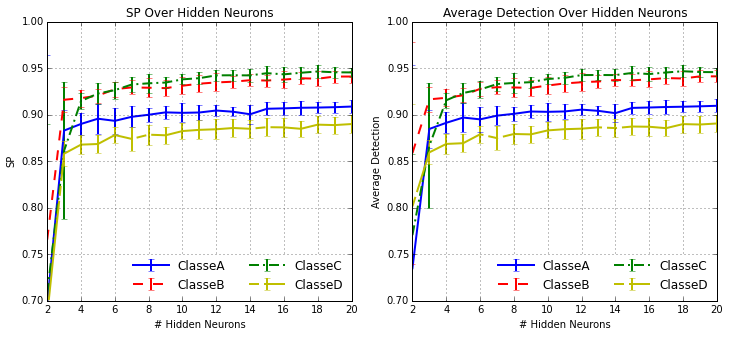

In [21]:
plt.figure(figsize=(12,5), facecolor='w')
non_nov_pds = {} # dictionary per novelty. Efficiency for non-novelties 
for inov, nov in enumerate(noveltyclasses):
    cv = nov_clf[nov]['Model']
    h_neurons = cv.results[0].nnets.keys() # should not change for different CV
    sps = np.zeros((cv.CVNSel, len(h_neurons)))
    pds = np.zeros((cv.CVNSel, len(h_neurons)))
    non_nov_pds[nov] = {}
    for nonnov in nov_clf[nov]['Classes']:
        non_nov_pds[nov][nonnov] = np.zeros((cv.CVNSel, len(h_neurons)))
    # Loop over CV
    for icv in range(cv.CVNSel):
        # Loop over hidden neurons
        for inh, nh in enumerate(cv.results[icv].nnets.keys()):
            trninfo = cv.results[icv].nnets[nh].trn_info
            ibest = trninfo.best_epoch
            sps[icv, inh] = trninfo.metrics['sp_tst'][ibest]
            pds[icv, inh] = np.mean([trninfo.metrics['eff_tst_c0'][ibest],
                                     trninfo.metrics['eff_tst_c1'][ibest],
                                     trninfo.metrics['eff_tst_c2'][ibest]])
            for i, nonnov in enumerate(nov_clf[nov]['Classes']):
                # indexes should be in the same order as novelty[nov]['Classes']
                non_nov_pds[nov][nonnov][icv,inh] = trninfo.metrics['eff_tst_c'+str(i)][ibest]
    # Plot SP
    plt.subplot(1,2,1)
    icls = np.nonzero(classes == nov)[0]
    plt.errorbar(h_neurons, np.mean(sps, axis=0), np.std(sps, axis=0),
                 color=colors[icls], dashes=dashes[icls], label=nov)
    # Plot PD
    plt.subplot(1,2,2)
    icls = np.nonzero(classes == nov)[0]
    plt.errorbar(h_neurons, np.mean(pds, axis=0), np.std(pds, axis=0),
                 color=colors[icls], dashes=dashes[icls], label=nov)
# Adjust plots
plt.subplot(1,2,1)
plt.title('SP Over Hidden Neurons')
plt.xlabel('# Hidden Neurons')
plt.ylabel('SP')
plt.ylim([0.7, 1])
plt.legend(loc='best', ncol=2).get_frame().set_color('1')
plt.grid()
plt.subplot(1,2,2)
plt.title('Average Detection Over Hidden Neurons')
plt.xlabel('# Hidden Neurons')
plt.ylabel('Average Detection')
plt.ylim([0.7, 1])
plt.legend(loc='best', ncol=2).get_frame().set_color('1')
plt.grid()

### Performance for each known-class

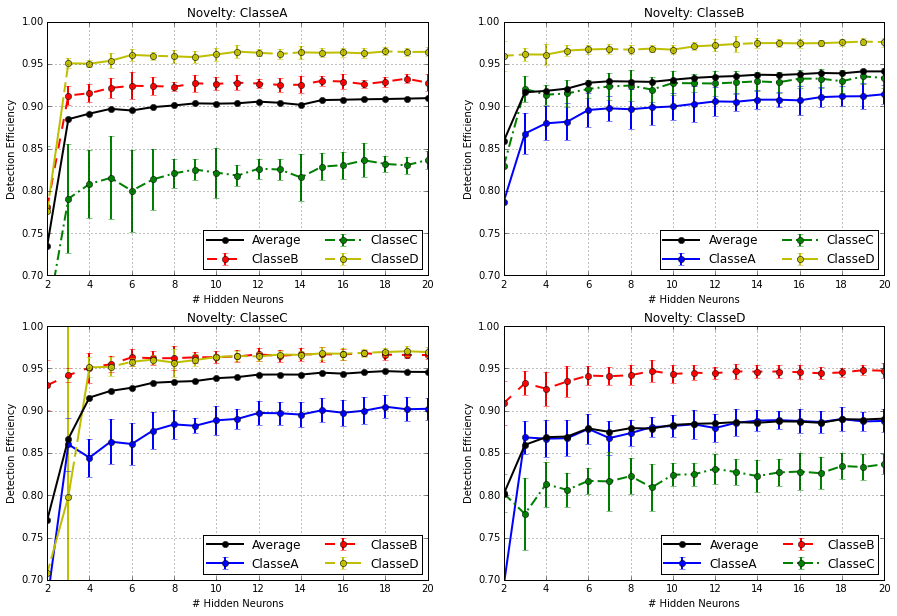

In [16]:
plt.figure(figsize=(15,10), facecolor='w')
for inov, nov in enumerate(noveltyclasses):
    plt.subplot(2,2,inov+1)
    # Loop over detected classes
    avgs = []
    for nonnov in non_nov_pds[nov]:
        icls = np.nonzero(classes == nonnov)[0] # the class index, not the novelty index
        avg_pds = np.mean(non_nov_pds[nov][nonnov], axis=0)
        std_pds = np.std(non_nov_pds[nov][nonnov], axis=0)
        plt.errorbar(h_neurons,avg_pds, std_pds, marker = 'o',
                     color=colors[icls], dashes=dashes[icls], label=nonnov)
        avgs.append(avg_pds)
    nov, '\t',         
    plt.plot(h_neurons,np.mean(avgs, axis=0), 'o-k', label='Average')
    plt.ylim([0.7,1])
    plt.grid()
    plt.xlabel('# Hidden Neurons')
    plt.ylabel('Detection Efficiency')
    plt.title('Novelty: ' + nov)
    plt.legend(loc='lower right',ncol=2).get_frame().set_facecolor('1')

## Simulation of the Final Network

The classifier task is to generalize the training. So, the best network is the one with the best performance for the test set.

In [17]:
nneurons = 12

In [18]:
iBestNet = {}
for inov, nov in enumerate(noveltyclasses):
    cv = nov_clf[nov]['Model']
    icv = np.argmax([cv.results[icv].nnets[nneurons].trn_info.perf for icv in range(cv.CVNSel)])
    nnet = cv.results[icv].nnets[nneurons] 
    ibest = nnet.trn_info.best_epoch
    sp = nnet.trn_info.perf*100
    mse = nnet.trn_info.metrics['mse_tst'][ibest]
    iBestNet[nov] = icv
    print nov + ', SP: %.2f'%(sp) + ', MSE: %.3f'%mse, ' #CV', icv

ClasseA, SP: 91.37, MSE: 0.153  #CV 4
ClasseB, SP: 94.36, MSE: 0.105  #CV 5
ClasseC, SP: 95.31, MSE: 0.090  #CV 3
ClasseD, SP: 89.91, MSE: 0.182  #CV 9


In [19]:
Y = {}
data = {}
for novcls in noveltyclasses:
    Y[novcls] = {}
    data[novcls] = {}
    NCV = nov_clf[novcls]['Model'].CVNSel
    # Over CV
    X, T, Xnov = novelty_data([novcls], cls_data)
    data[novcls]['Input'] = nov_pcdnet[novcls]['Net'].W[0].dot(X.transpose()).transpose()
    data[novcls]['Target'] = T 
    data[novcls]['InNov'] = nov_pcdnet[novcls]['Net'].W[0].dot(Xnov.transpose()).transpose()
    data[novcls]['Labels'] = nov_pcdnet[novcls]['Classes']         
    for icv in range(NCV):
        Y[novcls][icv] = {}
        nnet = nov_clf[novcls]['Model'].results[icv].nnets[nh]
        Y[novcls][icv]['Output'] = nnet.feedforward(data[novcls]['Input'])
        Y[novcls][icv]['OutNov'] = nnet.feedforward(data[novcls]['InNov'])
        #Y[novcls][icv]['ITest'] = nnet.trn_info.ival
        Y[novcls][icv]['ITest'] = range(T.shape[0])

### Ouput

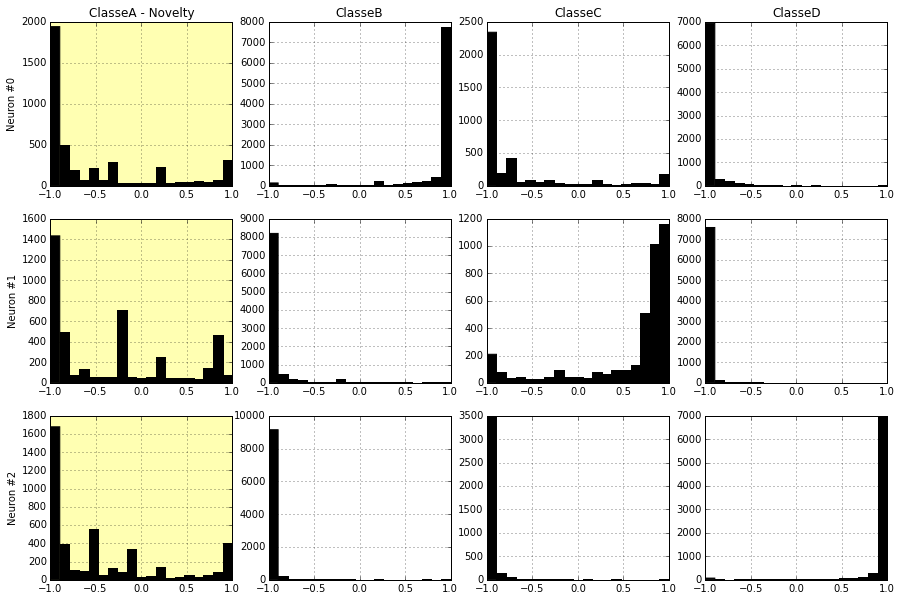

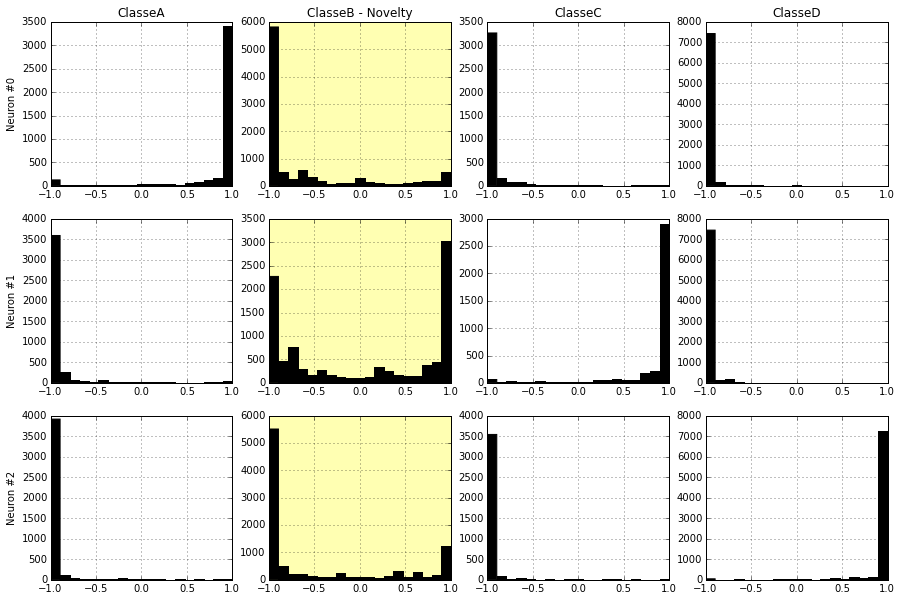

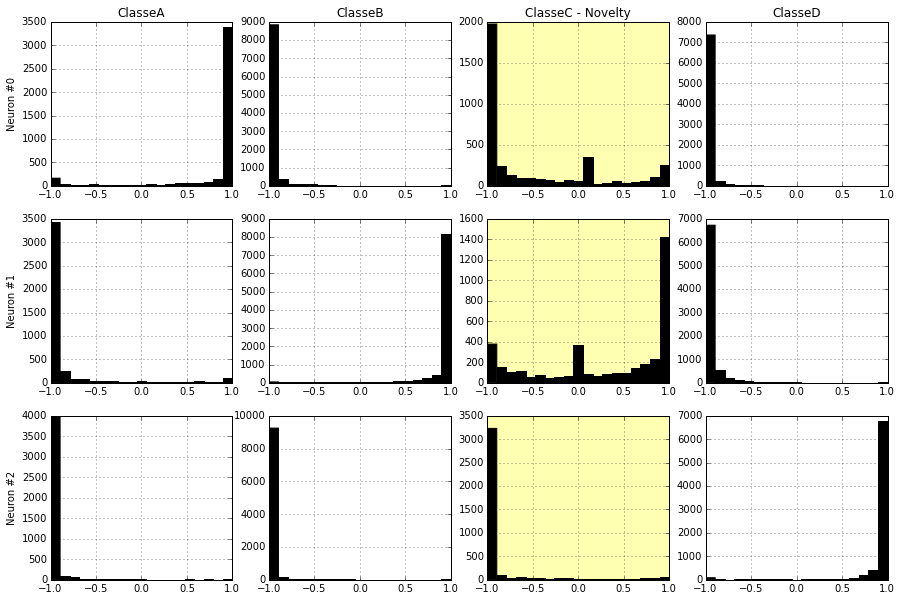

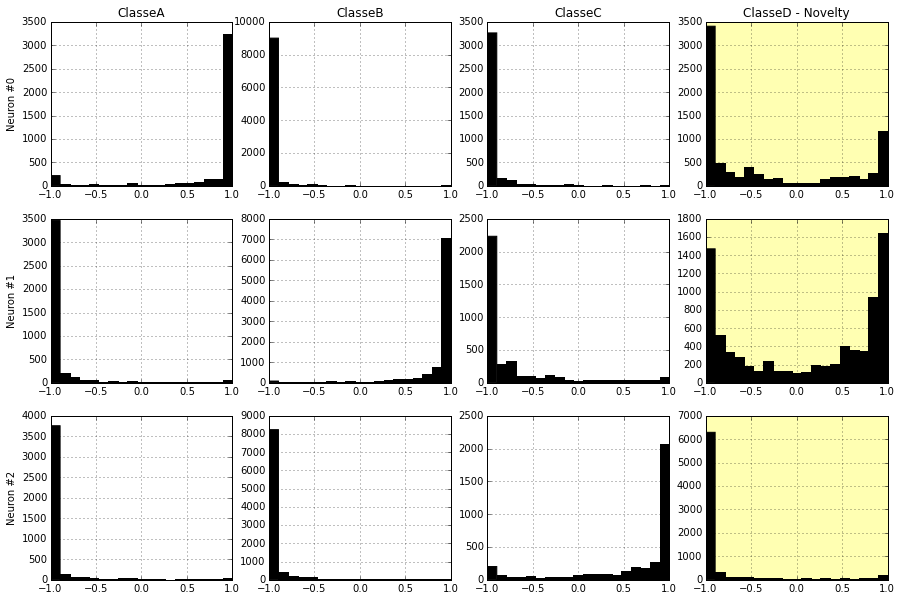

In [20]:
hbins = np.linspace(-1,1,20)
for novcls in noveltyclasses:
    plt.figure(figsize=(15,10), facecolor='w')
    iplt = 1
    itgt = np.argmax(data[novcls]['Target'], axis=1)
    itst = Y[novcls][iBestNet[novcls]]['ITest']
    idx = np.array([True] * itgt.shape[0])
    for iout in range(data[novcls]['Target'].shape[1]):
        for icls, cls in enumerate(data[novcls]['Labels']):
            clsNum = np.nonzero(classes == cls)[0][0]
            plt.subplot(3,4,(data[novcls]['Target'].shape[1]+1)*iout+1+clsNum)
            plt.hist(Y[novcls][iBestNet[novcls]]['Output'][(itgt==icls)&idx,iout], hbins, color='k');
            iplt = iplt + 1
            plt.grid(True)
        clsNum = np.nonzero(classes == novcls)[0][0] 
        plt.subplot(3,4,(data[novcls]['Target'].shape[1]+1)*iout+1+clsNum)
        plt.gca().set_axis_bgcolor('#ffff00')
        plt.gca().patch.set_alpha(0.3)
        plt.hist(Y[novcls][iBestNet[novcls]]['OutNov'][:,iout], hbins, color='k');
        #plt.gca().set_facecolor('#aaaa00')
        plt.grid(True)    
        iplt = iplt + 1
    # Labels
    for cls in data[novcls]['Labels']:
        clsNum = np.nonzero(classes == cls)[0][0] 
        plt.subplot(3,4,1+clsNum)
        plt.title(cls)
    clsNum = np.nonzero(classes == novcls)[0][0] 
    plt.subplot(3,4,1+clsNum)
    plt.title(novcls + ' - Novelty')
    # Neuron output
    for i in range(data[novcls]['Target'].shape[1]):
        plt.subplot(3,4,(data[novcls]['Target'].shape[1]+1)*i+1)
        plt.ylabel('Neuron #' + str(i))
    